In [1]:
from sklearn.feature_selection import RFE

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy, scipy as sklearn, librosa, urllib
import librosa.display
from IPython.display import Audio
import json 
import seaborn as sns
from sklearn.cluster import KMeans
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import keras
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from os import path

from itertools import cycle
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, silhouette_score,roc_auc_score, precision_recall_fscore_support
from tqdm import tqdm
import opensmile


import datetime

from keras import Model
from keras.layers import Dense, Input

In [52]:
def build_autoencoder(neurons_code=28, neuron_in=10, act_function="sigmoid", optimizer="adam", hidden_layers=0):
    # Input layer
    input_layer = Input(shape=(neuron_in,))

    encoded = Dense(neurons_code, activation='relu', name='hidden_1')(input_layer)
    # Bottleneck layer
    # encoded = Dense(2, activation='relu', name='bottleneck')(hidden_1)
    # hidden_2 = Dense(neurons_in, activation='relu', name='hidden_2')(encoded)

    # Output layer
    decoded = Dense(neuron_in, activation=act_function, name='decoded')(encoded)

    # Create the model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(loss="binary_crossentropy", optimizer=optimizer)

    return autoencoder
from datetime import datetime
class TimestampCallback(tf.keras.callbacks.Callback):
    def __init__(self, metric_name = "duration"):
        self.__epoch_start = None
        self.__metric_name = metric_name

    def on_epoch_begin(self, epoch, logs=None):
        self.__epoch_start = datetime.now()

    def on_epoch_end(self, epoch, logs=None):
        logs[self.__metric_name] = datetime.now() - self.__epoch_start

  
def train_autoencoder(emotion,data_t,data_v, index, code, input):
    # name = datetime.now().strftime(f"model/autoencoders/test/ae_{emotion}.keras")
    print(f"training on {emotion}")
    # print(f"Model name : {name}")
    ae = build_autoencoder(code,input,"sigmoid","adam",0)
    callbacks = [
    TimestampCallback(),
    # keras.callbacks.ModelCheckpoint(
    #     filepath = name,
    #     save_best_only=True,
    #     verbose=0,
    #     monitor="val_loss"),
    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.0001,
        patience=40,
        verbose=0,
        mode="auto",
        restore_best_weights=True
    )
    ]

    _X_train = data_t[index]
    _X_val = data_v[index]


    history = ae.fit(_X_train,_X_train,
                validation_data = (_X_val,_X_val),
                epochs=5000,
                batch_size=128,
                verbose=0,
                callbacks = callbacks)
   


    return ae, history.history["duration"]



def compute_dur(duration):
    tot = 0
    for i in range(len(duration)):
        tot += duration[i].microseconds / 1000

    return tot / i, i

In [6]:
def get_emo_df(emotion, dataframe):
    emo = []
    tot = 0
    print(f"Processing {emotion} ...")
    for id, name in zip(dataframe["filename"],dataframe["label"]):
        if f"{emotion}" in name:
            emo.append(id)
            tot += 1
    print(f"Processed {tot} file for {emotion}")


    mask = dataframe['filename'].isin(emo)
    emo_df = dataframe[mask].reset_index()
    emo_df = emo_df.drop(['index'], axis=1)
    return emo_df



def get_data(df,seed):
    X = pd.concat(df["features"].tolist(), ignore_index=True)
    _X= (X-X.min())/(X.max()-X.min())
    


    X_train, X_test = train_test_split(_X, test_size=.2, random_state=seed)
    X_train, X_val = train_test_split(X_train, test_size=.1, random_state=seed)
    # print(len(X_train), len(X_val), len(X_test))
    return X_train, X_val, X_test


In [147]:
clear_df = pd.read_pickle("utils/data/clear_demos.pkl")
clear_df = pd.read_pickle("utils/data/clear_functional_emovo.pkl")
# clear_df = pd.read_pickle("utils/data/clear_emozionalmente.pkl")
# clear_df = pd.read_pickle("utils/data/pitch_functional_demos.pkl")
# clear_df = pd.read_pickle("utils/data/pitch_functional_emovo.pkl")

labels = clear_df["label"].unique()    
features = clear_df["features"][0].columns.tolist()

In [148]:
df = []

for i,emotion in enumerate(labels):
    df.append(get_emo_df(emotion,clear_df))

Processing disgust ...
Processed 84 file for disgust
Processing joy ...
Processed 84 file for joy
Processing neutrality ...
Processed 84 file for neutrality
Processing fear ...
Processed 84 file for fear
Processing anger ...
Processed 84 file for anger
Processing surprise ...
Processed 84 file for surprise
Processing sadness ...
Processed 83 file for sadness


In [149]:
import random

train = []
val = []
test = []
seed = random.randint(0,100)
print(seed)
for data in df:
    tr, v, te = get_data(data, seed)
    train.append(tr)
    val.append(v)
    test.append(te)

59


In [150]:
y_train = []
for idx, data in enumerate(train):
    train_indices = np.full(len(data), idx)
    y_train.append(train_indices)
y_train = np.hstack(y_train)

y_val = []
for idx, data in enumerate(val):
    val_indices = np.full(len(data), idx)
    y_val.append(val_indices)
y_val = np.hstack(y_val)


y_test = []
for idx, data in enumerate(test):
    test_indices = np.full(len(data), idx)
    y_test.append(test_indices)
y_test = np.hstack(y_test)

In [151]:
X_train = np.vstack(train)
X_val = np.vstack(val)
X_test = np.vstack(test)

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression



# regressor = LogisticRegression(random_state=22)
regressor = RandomForestRegressor(n_estimators=100, max_depth=100, n_jobs=-1)




from sklearn.feature_selection import RFE, RFECV

n_features_to_select = 10

# rfe = RFE(regressor, n_features_to_select=n_features_to_select, verbose=3)

rfe = RFECV(regressor, step=1, cv=5, verbose=0)
rfe.fit(X_train, y_train)




RFECV(cv=5, estimator=RandomForestRegressor(max_depth=100, n_jobs=-1))

In [41]:
mask = np.where(rfe.ranking_ < 6, True, False)

In [42]:
new_feat = np.array(features)[mask]

In [152]:
new_feat

array(['mfcc3_sma3_stddevNorm', 'mfcc4_sma3_stddevNorm',
       'logRelF0-H1-H2_sma3nz_stddevNorm',
       'logRelF0-H1-A3_sma3nz_stddevNorm', 'mfcc3V_sma3nz_stddevNorm'],
      dtype='<U46')

In [153]:
new_train = X_train[:,rfe.support_]
new_val = X_val[:,rfe.support_]
new_test = X_test[:,rfe.support_]

In [154]:
new_train = []
new_val = []
new_test = []

for i in range(len(train)):
    new_train.append(train[i].to_numpy()[:,mask])
    new_val.append(val[i].to_numpy()[:,mask])
    new_test.append(test[i].to_numpy()[:,mask])

5

In [59]:
new_train[0].shape

(709, 5)

In [60]:
train[0].to_numpy().shape

(709, 88)

In [155]:
autoencoders = []
durations = []
for i,emotion in enumerate(labels):
    # autoencoders.append(train_autoencoder(emotion, df[i], i))
    ae, dur = train_autoencoder(emotion, new_train, new_val, i,2,new_feat.shape[0] )
    autoencoders.append(ae)
    durations.append(dur)

training on disgust
training on joy
training on neutrality
training on fear
training on anger
training on surprise
training on sadness


In [156]:
from sklearn.metrics import mean_squared_error

def obtain_predictions(test, autoencoders):
    y_true = []

    y_pred = []
    errors = []
    _test = []
    for n in range(len(test)):
        _test.append(test[n])
    for n in tqdm(range(len(df))):
        X_test = _test[n]
        
        cls = []

        for i in (range(len(X_test))):
            _er = []
            for encoder in autoencoders:
            #print(labels[x])
                _er.append(mean_squared_error(X_test[i],encoder.predict(X_test[i].reshape(-1,X_test.shape[1]), verbose=0).reshape(X_test.shape[1],)))
            errors.append(_er)
            y_pred.append(np.argmin(_er))
            y_true.append(n)
    return errors, y_true, y_pred

    #pred.append(cls)
    # print(cls)


def obtain_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true,y_pred)

    g = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True)
    g.xaxis.set_ticklabels(labels, rotation = 15,fontsize=12)
    g.yaxis.set_ticklabels(labels, rotation = 30,fontsize=12)
    g.set_xlabel("Predicted Label", fontsize=14)
    g.set_ylabel("True Label", fontsize = 14)
    g.set_title(title)
    
    name = title + ".png"
    plt.tight_layout()
    plt.show()
    # g.figure.savefig(name)

# g.set_title(data, fontsize = 18)

100%|██████████| 7/7 [00:29<00:00,  4.19s/it]


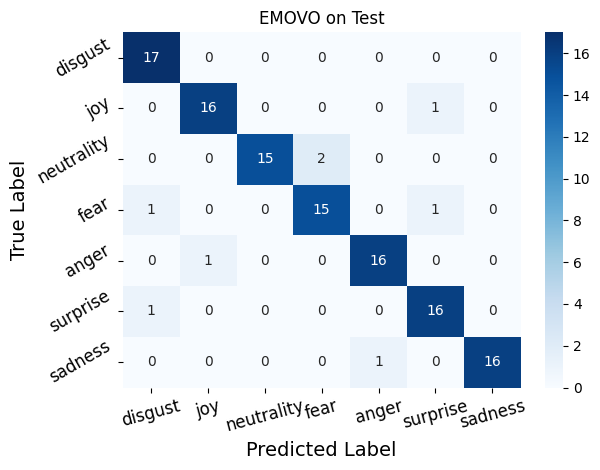

0.9327731092436975

In [157]:
train_errors, y_true, y_pred = obtain_predictions(new_test, autoencoders)
obtain_cm(y_true, y_pred, labels, "EMOVO on Test")
accuracy_score(y_true, y_pred)  #0.9969104016477858

7

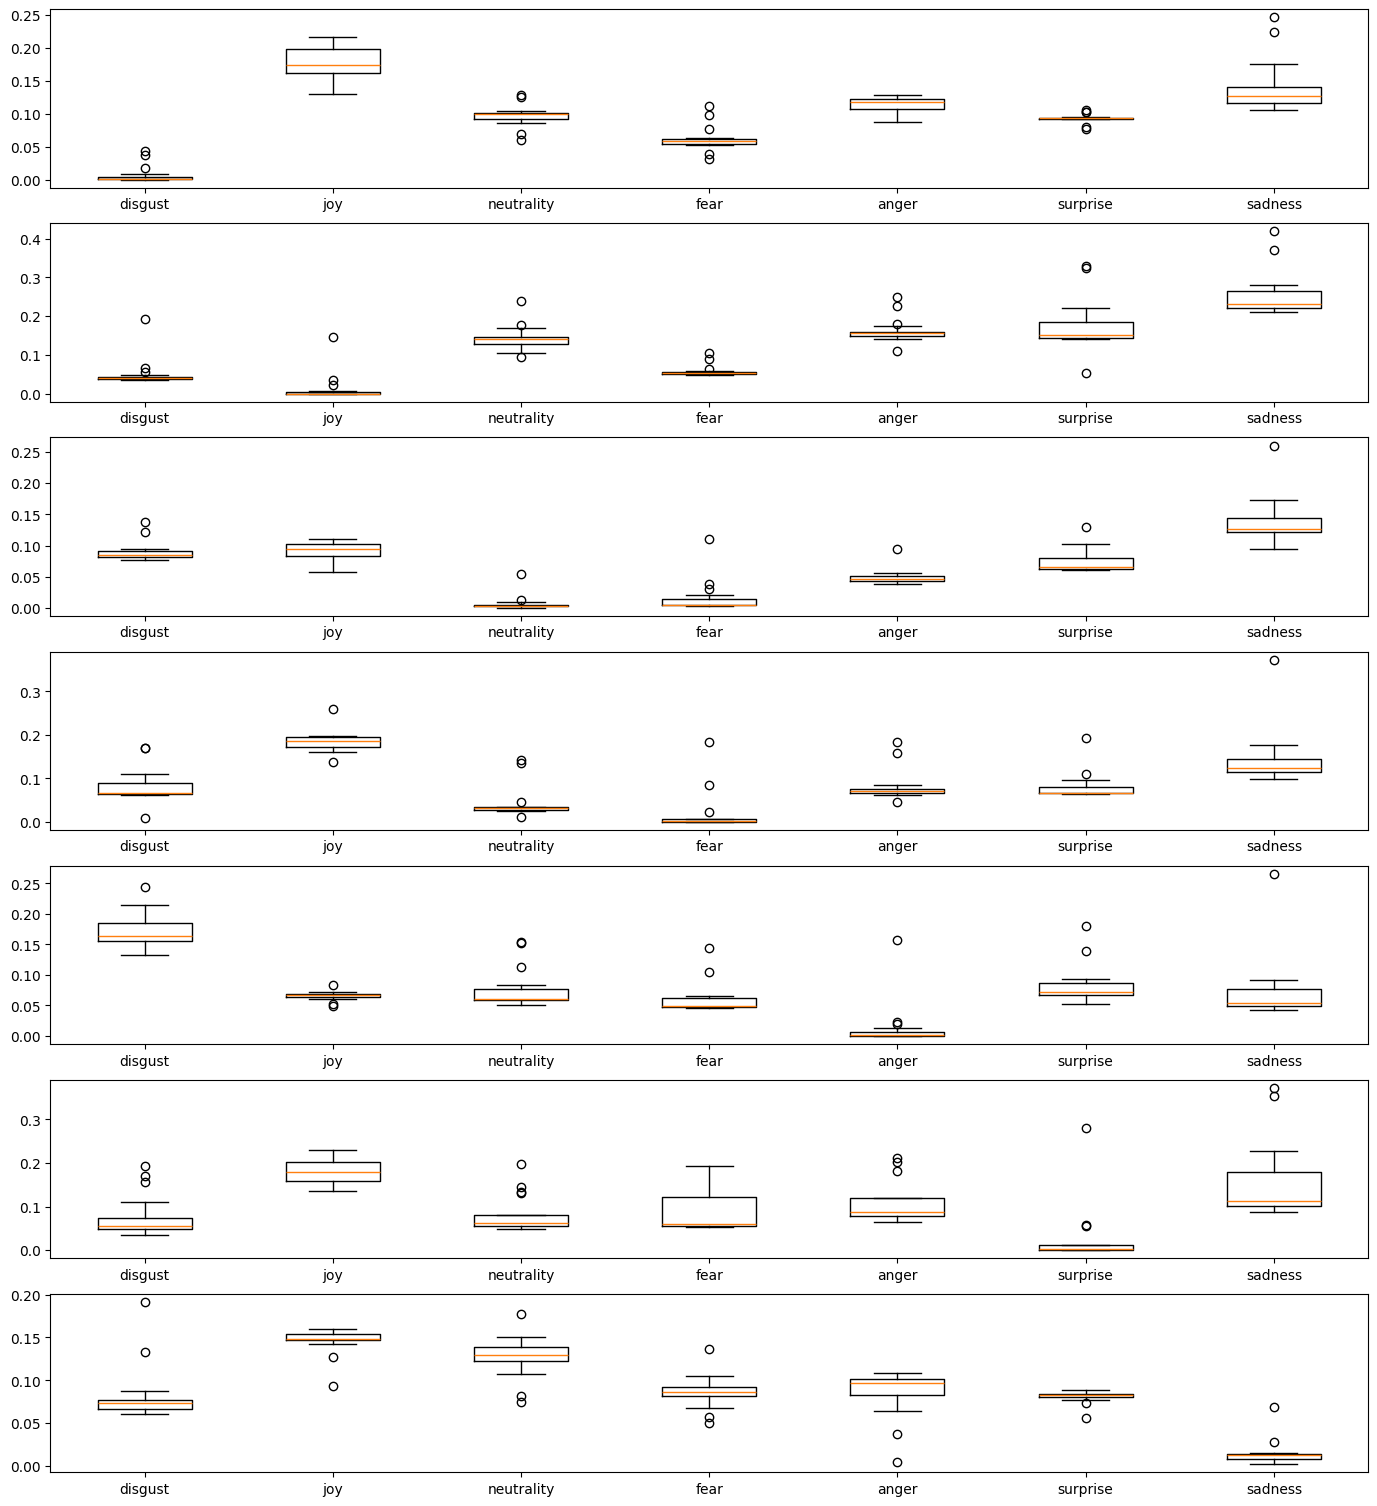

In [161]:
# Initialize 8 empty emo
emo = [[] for _ in range(len(labels))]

# Iterate over y_true and append the corresponding index to the appropriate sublist
for idx, value in enumerate(y_true):
    emo[value].append(train_errors[idx])
    
test_emo = []
for em in emo:
    test_emo.append(np.array(em))



n_rows = len(test_emo)
fig, axes = plt.subplots(nrows=n_rows, ncols=1, figsize=(17,19))
for i in range(len(test_emo)):
    axes[i].boxplot([test_emo[i][:, j] for j in range(len(test_emo))], tick_labels=labels )


100%|██████████| 8/8 [09:58<00:00, 74.82s/it] 


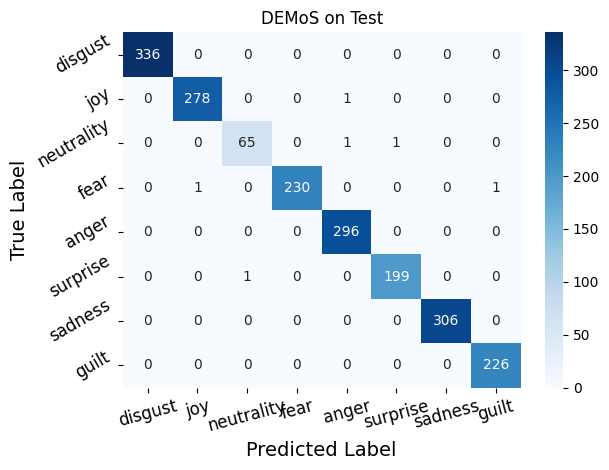

In [80]:
train_errors, y_true, y_pred = obtain_predictions(new_test, autoencoders)
obtain_cm(y_true, y_pred, labels, "DEMoS on Test")
accuracy_score(y_true, y_pred)  #0.9969104016477858

In [82]:
data_test = np.array(train_errors)

In [97]:
# Initialize 8 empty emo
emo = [[] for _ in range(8)]

# Iterate over y_true and append the corresponding index to the appropriate sublist
for idx, value in enumerate(y_true):
    emo[value].append(train_errors[idx])


Sublist 0: [[1.7717482e-05, 0.06619257, 0.1504744, 0.17599043, 0.15861568, 0.08628846, 0.19168426, 0.05172775], [1.2845054e-05, 0.06583969, 0.15029618, 0.17528282, 0.15811837, 0.086652294, 0.19042084, 0.05127374], [8.8593315e-06, 0.06500714, 0.14957228, 0.17428996, 0.15733953, 0.08585067, 0.18963769, 0.05186819], [6.6549283e-06, 0.06538638, 0.14994937, 0.17489105, 0.15759282, 0.0858411, 0.18975583, 0.052109282], [7.5595162e-06, 0.0656165, 0.15026084, 0.17523055, 0.15778686, 0.08602451, 0.18973725, 0.052078724], [0.00038503666, 0.064474575, 0.14536674, 0.16979176, 0.15154232, 0.08958785, 0.19526365, 0.047578007], [3.6978006e-06, 0.065926515, 0.15024614, 0.17534335, 0.15721804, 0.08637959, 0.18986782, 0.05194682], [3.5713878e-05, 0.06501783, 0.14799118, 0.17293826, 0.15549156, 0.08685638, 0.19130833, 0.050391175], [2.4132853e-05, 0.06728964, 0.15158524, 0.17693534, 0.15856677, 0.08792058, 0.19070692, 0.050771337], [1.1259062e-05, 0.06550978, 0.15019831, 0.17513677, 0.15811874, 0.08598504

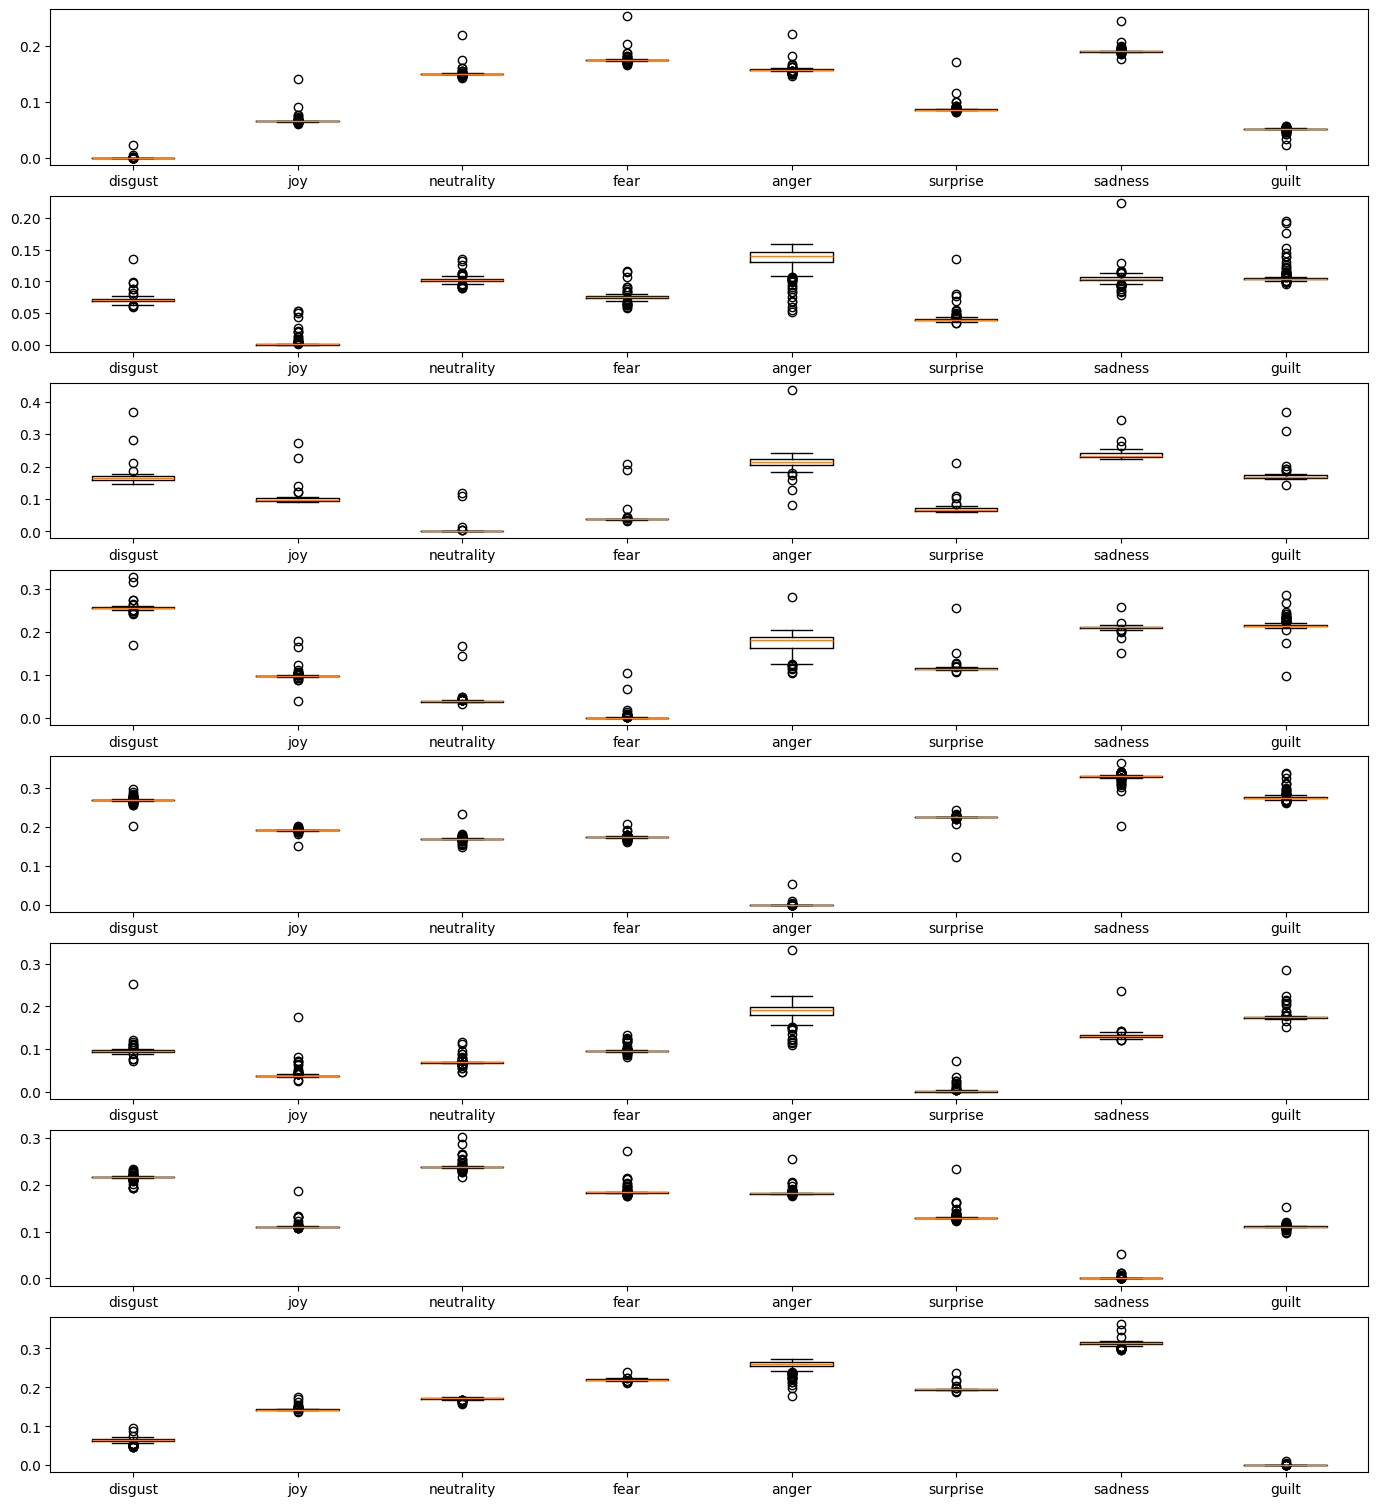

In [ ]:

n_rows = len(test_emo)
fig, axes = plt.subplots(nrows=n_rows, ncols=1, figsize=(17,19))
for i in range(len(test_emo)):
    axes[i].boxplot([test_emo[i][:, j] for j in range(len(test_emo))], tick_labels=labels )


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [05:55<00:00, 50.82s/it]


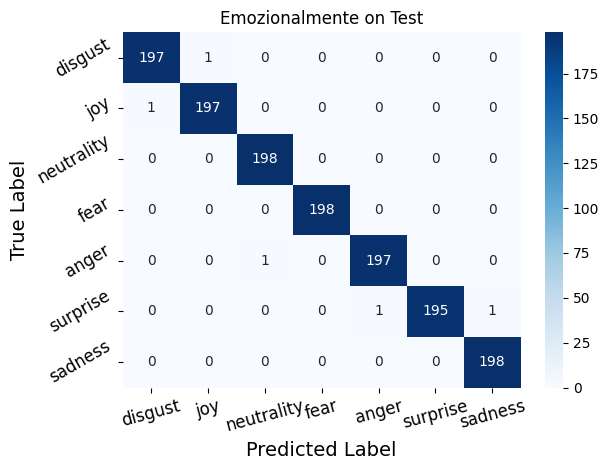

In [72]:
train_errors, y_true, y_pred = obtain_predictions(new_test, autoencoders)
obtain_cm(y_true, y_pred, labels, "Emozionalmente on Test")
# accuracy_score(y_true, y_pred)

In [95]:
from sklearn.feature_selection import mutual_info_classif


y = np.hstack([y_train, y_val, y_test])
X = np.vstack([X_train, X_val, X_test])

Res = mutual_info_classif(X, y)
from operator import itemgetter
features
best_features = []
for x1, x2 in (sorted(zip(Res , features), key=itemgetter(0), reverse= True)):
    # if x1 == 1:
        # print(x1)
        best_features.append(x2)

# best_features

In [96]:
best_features

['mfcc3V_sma3nz_stddevNorm',
 'mfcc2V_sma3nz_stddevNorm',
 'logRelF0-H1-H2_sma3nz_stddevNorm',
 'slopeV0-500_sma3nz_stddevNorm',
 'mfcc4V_sma3nz_stddevNorm',
 'mfcc2_sma3_stddevNorm',
 'mfcc4_sma3_stddevNorm',
 'HNRdBACF_sma3nz_stddevNorm',
 'mfcc3_sma3_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'logRelF0-H1-A3_sma3nz_stddevNorm',
 'MeanUnvoicedSegmentLength',
 'slopeV500-1500_sma3nz_stddevNorm',
 'alphaRatioV_sma3nz_stddevNorm',
 'MeanVoicedSegmentLengthSec',
 'mfcc1_sma3_stddevNorm',
 'logRelF0-H1-H2_sma3nz_amean',
 'logRelF0-H1-A3_sma3nz_amean',
 'hammarbergIndexV_sma3nz_stddevNorm',
 'F3frequency_sma3nz_amean',
 'VoicedSegmentsPerSec',
 'F2frequency_sma3nz_amean',
 'mfcc1V_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'loudnessPeaksPerSec',
 'F1bandwidth_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F1frequency_sma3nz_amean',
 'shimmerLocaldB_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_amean',
 'HNRdBACF_sma3nz_amean

<BarContainer object of 88 artists>

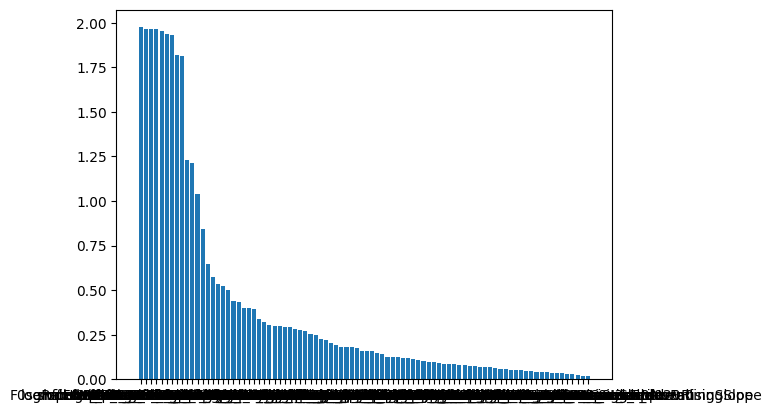

In [87]:
plt.bar(best_features, sorted(Res,reverse=True))

In [88]:
n = sorted(Res,reverse=True)

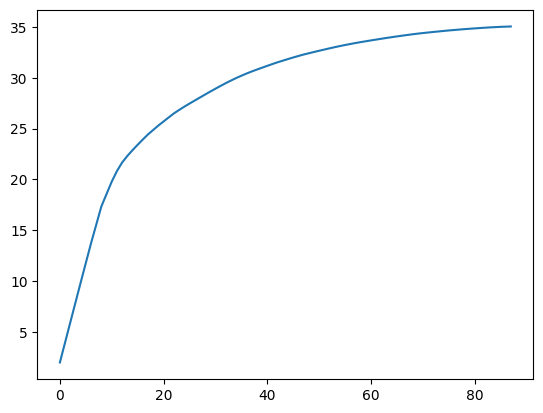

In [89]:
a = np.cumsum(n)

plt.plot(a)

In [90]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=100, n_features=10, n_informative=2, n_clusters_per_class=1,
    shuffle=False, random_state=42
)

In [91]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [92]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
norm = scaler.fit(Res)
# sorted(Res, reverse=True)
norm

ValueError: Expected 2D array, got 1D array instead:
array=[0.29113163 0.04520718 0.27297756 0.33752316 0.29781757 0.11523635
 0.25302841 0.0192378  1.22728701 0.02665258 0.05073399 0.08447154
 0.01832684 0.03505314 0.05730157 0.07058956 0.04142394 0.03912404
 0.10937155 0.21922175 0.04721667 0.10444979 0.09581609 0.53318906
 0.08057423 1.93637181 0.03587513 1.81623    0.02551091 1.93297334
 0.17349921 0.08405144 0.14597806 0.29477579 0.28299589 1.81760863
 0.52230695 1.96449243 0.49972852 1.21400032 0.29581244 0.07441796
 0.30356012 0.18241956 0.03358637 0.2472765  0.399794   0.08000342
 0.20212444 0.11751901 0.05141043 0.07629407 0.43495998 0.09809712
 0.22447339 0.06644921 0.05426841 0.12002952 0.14260269 0.64429037
 0.15664186 0.43920046 0.08242718 1.96318845 0.09060578 0.84084707
 0.12228068 0.1892448  0.1562862  0.39411997 0.04212332 1.96594361
 0.05239866 1.97585042 0.03163036 1.95598925 0.124503   0.12443532
 0.1576779  0.06470482 0.18306978 0.3226223  0.40059254 0.571186
 0.07068192 1.04024401 0.27790126 0.18040453].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [60]:
for i in range(len(best_features)):
    print(best_features[i])

mfcc1_sma3_stddevNorm
F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2
MeanVoicedSegmentLengthSec
StddevVoicedSegmentLengthSec
F0semitoneFrom27.5Hz_sma3nz_percentile80.0
mfcc1_sma3_amean
VoicedSegmentsPerSec
alphaRatioV_sma3nz_amean
loudnessPeaksPerSec
F0semitoneFrom27.5Hz_sma3nz_percentile50.0
F3amplitudeLogRelF0_sma3nz_amean
mfcc1V_sma3nz_amean
F3amplitudeLogRelF0_sma3nz_stddevNorm
StddevUnvoicedSegmentLength
F1amplitudeLogRelF0_sma3nz_stddevNorm
mfcc1V_sma3nz_stddevNorm
alphaRatioV_sma3nz_stddevNorm
MeanUnvoicedSegmentLength
F0semitoneFrom27.5Hz_sma3nz_stddevNorm
F0semitoneFrom27.5Hz_sma3nz_amean
mfcc3V_sma3nz_stddevNorm
mfcc2_sma3_stddevNorm
F2amplitudeLogRelF0_sma3nz_amean
mfcc3_sma3_stddevNorm
F0semitoneFrom27.5Hz_sma3nz_percentile20.0
F1amplitudeLogRelF0_sma3nz_amean
mfcc2V_sma3nz_stddevNorm
F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope
slopeV500-1500_sma3nz_stddevNorm
slopeUV500-1500_sma3nz_amean
F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope
hammarbergIndexV_sma3nz_amean
mfcc2_sma3_amean


In [37]:
import pickle

# Save the dictionary to a .pkl file
with open('rfe_cv_res.pkl', 'wb') as f:
    pickle.dump(rfe.cv_results_, f)

In [38]:

with open('rfe_cv_res.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [35]:
rfe.n_features_

51

In [37]:
rfe.support_

array([False,  True, False, False,  True,  True, False,  True,  True,
       False, False,  True, False, False, False,  True,  True,  True,
       False,  True, False, False, False,  True, False, False,  True,
       False, False, False, False,  True,  True,  True, False, False,
        True,  True, False,  True, False,  True, False,  True, False,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True, False, False, False,  True,  True, False, False,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False])

In [36]:
rfe.cv_results_["n_features"]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88])

In [43]:
rfe.cv_results_["mean_test_score"]

array([-0.44138013, -0.11624642, -0.03982877,  0.00340859,  0.03527924,
        0.0612626 ,  0.0765724 ,  0.08637663,  0.09464394,  0.0976202 ,
        0.10024621,  0.10771391,  0.11244751,  0.11304962,  0.11636096,
        0.11767203,  0.11788883,  0.11891165,  0.12147895,  0.12210513,
        0.12232049,  0.12366973,  0.12534541,  0.12512421,  0.12427082,
        0.12509166,  0.12318506,  0.12359827,  0.12326011,  0.1238168 ,
        0.12576028,  0.12346335,  0.12581792,  0.12513828,  0.12535521,
        0.12602032,  0.12636592,  0.1261269 ,  0.12530722,  0.12653385,
        0.1267975 ,  0.12387767,  0.1269857 ,  0.12563726,  0.12568236,
        0.12513053,  0.12352363,  0.12548093,  0.12427338,  0.12396972,
        0.12692782,  0.12563017,  0.12468076,  0.123686  ,  0.12534928,
        0.126206  ,  0.12733905,  0.12488956,  0.12419654,  0.12361957,
        0.12461671,  0.1263063 ,  0.12360567,  0.12565025,  0.12429756,
        0.12645115,  0.12394007,  0.12523587,  0.12515193,  0.12

(0.0, 10.0)

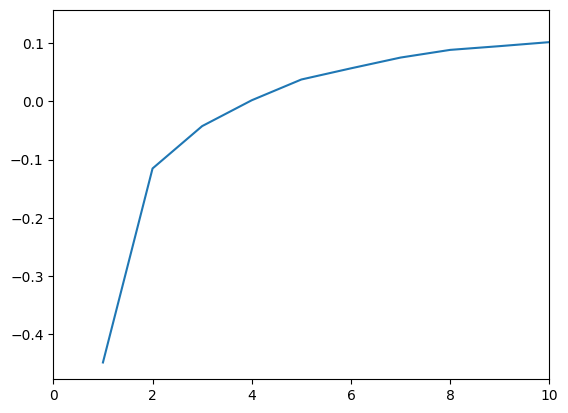

In [66]:
plt.plot(rfe.cv_results_["n_features"], rfe.cv_results_["mean_test_score"])
plt.xlim([0,10])

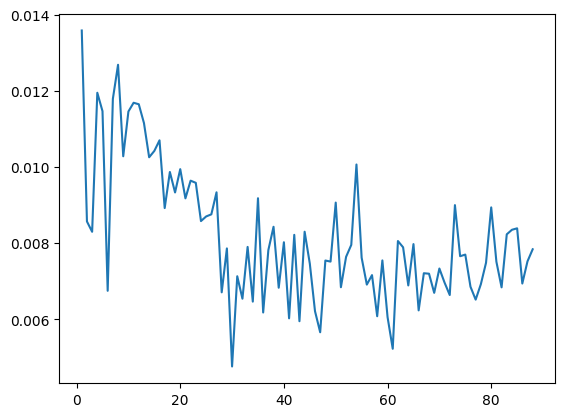

In [14]:
plt.plot(rfe.cv_results_["n_features"], rfe.cv_results_["std_test_score"])

In [41]:
rfe.cv_results_["split0_test_score"]

array([-4.74195657e-01, -1.18451734e-01, -4.91463685e-02,  2.31929503e-04,
        3.18782743e-02,  5.23717196e-02,  7.42351963e-02,  8.73866565e-02,
        9.09584682e-02,  9.64185551e-02,  1.01519664e-01,  1.03199815e-01,
        1.08489345e-01,  1.11769425e-01,  1.16471586e-01,  1.17828768e-01,
        1.14839780e-01,  1.17928529e-01,  1.10979179e-01,  1.14642285e-01,
        1.15448081e-01,  1.23530314e-01,  1.18987941e-01,  1.23342076e-01,
        1.19451213e-01,  1.17518712e-01,  1.18200061e-01,  1.21314130e-01,
        1.21464965e-01,  1.19325138e-01,  1.24851226e-01,  1.25304580e-01,
        1.20044729e-01,  1.22038460e-01,  1.25660700e-01,  1.23211596e-01,
        1.24633992e-01,  1.24975646e-01,  1.21429547e-01,  1.25940986e-01,
        1.19838571e-01,  1.24596101e-01,  1.24249409e-01,  1.23400925e-01,
        1.22193120e-01,  1.24618301e-01,  1.22663015e-01,  1.23282922e-01,
        1.24014878e-01,  1.25678741e-01,  1.31899434e-01,  1.21904705e-01,
        1.23665636e-01,  

In [42]:
rfe.cv_results_["split1_test_score"]

array([-0.45480798, -0.09720233, -0.01814443,  0.02621143,  0.04987701,
        0.06652962,  0.09108209,  0.0982691 ,  0.10904384,  0.11445734,
        0.11810646,  0.12345023,  0.12776509,  0.13000955,  0.12660003,
        0.13300817,  0.13098281,  0.13144924,  0.13207675,  0.13842994,
        0.13989325,  0.13804086,  0.13312308,  0.13957078,  0.14017838,
        0.13578352,  0.13148983,  0.13729817,  0.13824553,  0.13791389,
        0.13247549,  0.13527357,  0.13602193,  0.13486358,  0.13259121,
        0.13979286,  0.13469701,  0.13593461,  0.13100858,  0.13167654,
        0.13375996,  0.13483356,  0.13381519,  0.13338553,  0.13143245,
        0.13084435,  0.13078988,  0.12987952,  0.12601562,  0.12869054,
        0.1302639 ,  0.13412515,  0.13611996,  0.13020019,  0.12983651,
        0.13420498,  0.12856629,  0.1307063 ,  0.13267933,  0.13059165,
        0.13181475,  0.13600207,  0.13445411,  0.13096585,  0.13545133,
        0.1332417 ,  0.1336003 ,  0.13650454,  0.13301235,  0.12

In [15]:
rfe.cv_results_["mean_test_score"]

array([-0.44310448, -0.1167673 , -0.04236571,  0.00596806,  0.03385576,
        0.0592359 ,  0.07500525,  0.08680241,  0.09383613,  0.10101742,
        0.10323303,  0.10687312,  0.10978435,  0.11397482,  0.11622926,
        0.11651882,  0.11889568,  0.11857176,  0.11995418,  0.11971247,
        0.1237108 ,  0.12365064,  0.12562784,  0.12591407,  0.12350052,
        0.1248098 ,  0.12435436,  0.12320699,  0.12117064,  0.12489312,
        0.12444244,  0.12391816,  0.12643753,  0.12495227,  0.12370454,
        0.12558722,  0.12806881,  0.12628235,  0.12541091,  0.12609042,
        0.1263937 ,  0.12699974,  0.12671309,  0.12453339,  0.12457002,
        0.12560456,  0.12651321,  0.12596824,  0.12459439,  0.12536629,
        0.12490573,  0.12668812,  0.12596708,  0.12530043,  0.12593822,
        0.1253537 ,  0.12527921,  0.12565386,  0.12684164,  0.12537114,
        0.12375441,  0.12375272,  0.12528576,  0.12463616,  0.1251808 ,
        0.12324888,  0.1254296 ,  0.12313662,  0.12574103,  0.12

In [40]:
rfe.ranking_

array([36,  1, 22, 30,  1,  1, 12,  1,  1,  9, 37,  1, 11, 32, 33,  1,  1,
        1,  5,  1, 35, 14,  7,  1, 24, 10,  1, 23, 29, 20,  4,  1,  1,  1,
       28, 19,  1,  1, 17,  1, 16,  1,  2,  1, 27,  1,  1,  1,  1,  1, 38,
       31,  1,  1,  1, 18, 34, 15,  1,  1, 21, 13,  1,  1,  1,  1,  8,  1,
        1,  1,  1,  1,  1,  3,  1,  6, 25,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, 26])

In [17]:
rfe.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [61]:
from operator import itemgetter
features = X_train.columns.to_list()
best_features_rfe = []
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    if x == 1:
        print(y)
        best_features_rfe.append(y)

F0semitoneFrom27.5Hz_sma3nz_stddevNorm
F0semitoneFrom27.5Hz_sma3nz_percentile80.0
F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2
F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope
F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope
loudness_sma3_stddevNorm
loudness_sma3_pctlrange0-2
loudness_sma3_meanRisingSlope
loudness_sma3_stddevRisingSlope
loudness_sma3_stddevFallingSlope
mfcc1_sma3_stddevNorm
mfcc3_sma3_amean
jitterLocal_sma3nz_stddevNorm
shimmerLocaldB_sma3nz_amean
shimmerLocaldB_sma3nz_stddevNorm
logRelF0-H1-H2_sma3nz_amean
logRelF0-H1-H2_sma3nz_stddevNorm
logRelF0-H1-A3_sma3nz_stddevNorm
F1frequency_sma3nz_stddevNorm
F1bandwidth_sma3nz_stddevNorm
F1amplitudeLogRelF0_sma3nz_stddevNorm
F2frequency_sma3nz_amean
F2frequency_sma3nz_stddevNorm
F2bandwidth_sma3nz_amean
F2bandwidth_sma3nz_stddevNorm
F3frequency_sma3nz_amean
F3frequency_sma3nz_stddevNorm
F3bandwidth_sma3nz_amean
alphaRatioV_sma3nz_amean
alphaRatioV_sma3nz_stddevNorm
slopeV0-500_sma3nz_amean
slopeV0-500_sma3nz_stddevNorm
slopeV500-1500_sm

In [82]:
best_features[:10]

['mfcc1_sma3_stddevNorm',
 'MeanVoicedSegmentLengthSec',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'StddevVoicedSegmentLengthSec',
 'mfcc1_sma3_amean',
 'alphaRatioV_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F3amplitudeLogRelF0_sma3nz_amean',
 'mfcc1V_sma3nz_amean']

In [83]:
best_features_rfe[:10]

['F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_n, Y, test_size=0.1, random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)

In [29]:
from datetime import datetime  
name = datetime.now().strftime("model/SER_DEMoS_41feat_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=1,
        monitor="val_loss"),

    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=15,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]


model = get_cnn((X_train.shape[1:]))
model.summary()

history = model.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       batch_size=32,
                       epochs=1000,
                       callbacks=callbacks)


print(f"Loss : {model.evaluate(X_test,y_test)[0]}, Accuracy : {model.evaluate(X_test,y_test)[1]}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 4095)           │       171,990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2048)           │     8,388,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,358,398 (43.33 MB)

 Trainable params: 11,358,398 (43.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1557 - loss: 24.8528
Epoch 1: val_loss improved from inf to 2.21370, saving model to model/SER_DEMoS_41feat_05_11_2024_14_39_34.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.1557 - loss: 24.7031 - val_accuracy: 0.1094 - val_loss: 2.2137
Epoch 2/1000
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1406 - loss: 2.2304
Epoch 2: val_loss improved from 2.21370 to 2.02475, saving model to model/SER_DEMoS_41feat_05_11_2024_14_39_34.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.1407 - loss: 2.2389 - val_accuracy: 0.1489 - val_loss: 2.0247
Epoch 3/1000
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1541 - loss: 2.0778
Epoch 3: val_loss improved from 2.02475 to 2.02292, saving model to model/SER_DEMoS_41feat_05_11_2024_14_39_34.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.1541 - loss: 2.0787 - val_accuracy: 0.1523 - val_loss: 2.0229
Epoch 4/1000
218/219 ━━━━━━━━━

In [25]:
from keras import layers, models
def get_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    encoder = layers.LSTM(256)(inputs)
    drop = layers.Dropout(0.3)(encoder)
    hidden1 = layers.Dense(128, activation='relu')(drop)

    hidden2 = layers.Dense(64, activation='relu')(hidden1)
    hidden = layers.Dense(32, activation='relu')(hidden2)
    outputs = layers.Dense(8, activation='softmax')(hidden)
    
    model = models.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

    return model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.expand_dims(X_n,axis=2), Y, test_size=0.1, random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)

In [ ]:
LSTM_model = get_model((X_train.shape[1:]))
LSTM_model.summary()


from datetime import datetime  
name = datetime.now().strftime("model/lstm_41feat_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=1,
        monitor="val_loss"),

    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=20,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]


LSTM_history = LSTM_model.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       batch_size=32,
                       epochs=1000,
                       verbose=1,
                       callbacks=callbacks)


print(f"Loss : {LSTM_model.evaluate(X_test,y_test)[0]}, Accuracy : {LSTM_model.evaluate(X_test,y_test)[1]}")

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,688 (1.17 MB)

 Trainable params: 307,688 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
218/219 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1461 - loss: 2.0392
Epoch 1: val_loss improved from inf to 2.00979, saving model to model/lstm_28_feat_05_11_2024_11_45_26.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.1463 - loss: 2.0391 - val_accuracy: 0.1569 - val_loss: 2.0098
Epoch 2/1000
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1668 - loss: 2.0234
Epoch 2: val_loss did not improve from 2.00979
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.1669 - loss: 2.0233 - val_accuracy: 0.1690 - val_loss: 2.0207
Epoch 3/1000
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1786 - loss: 2.0128
Epoch 3: val_loss improved from 2.00979 to 1.99227, saving model to model/lstm_28_feat_05_11_2024_11_45_26.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1785 - loss: 2.0128 - val_accuracy: 0.1924 - val_loss: 1.9923
Epoch 4/1000
217/219 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1739 - loss: 2.0148
Epoch 4: val_loss imp

(9696, 41)

In [42]:
from datetime import datetime  
name = datetime.now().strftime("model/SER_DEMoS_function_%d_%m_%Y_%H_%M_%S.keras")  

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = name,
        save_best_only=True,
        verbose=1,
        monitor="val_loss"),

    keras.callbacks.EarlyStopping(  
        monitor="val_loss",
        min_delta=0.001,
        patience=15,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
]



X_train, X_test, y_train, y_test = train_test_split(np.expand_dims(X_n,axis=2), Y, test_size=0.1, random_state=22)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=22)


model = get_model((X_train.shape[1:]))
model.summary()

history = model.fit(X_train, y_train, 
                       validation_data=(X_val,y_val), 
                       batch_size=32,
                       epochs=1000,
                       callbacks=callbacks)


print(f"Loss : {model.evaluate(X_test,y_test)[0]}, Accuracy : {model.evaluate(X_test,y_test)[1]}")

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 39, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 18, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 7, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,016 (558.66 KB)

 Trainable params: 143,016 (558.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1532 - loss: 4.1102
Epoch 1: val_loss improved from inf to 2.05900, saving model to model/SER_DEMoS_function_05_11_2024_15_12_58.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1532 - loss: 4.1033 - val_accuracy: 0.1569 - val_loss: 2.0590
Epoch 2/1000
209/219 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1567 - loss: 2.0613
Epoch 2: val_loss improved from 2.05900 to 2.03955, saving model to model/SER_DEMoS_function_05_11_2024_15_12_58.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1570 - loss: 2.0610 - val_accuracy: 0.1672 - val_loss: 2.0395
Epoch 3/1000
208/219 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1713 - loss: 2.0411
Epoch 3: val_loss improved from 2.03955 to 2.02684, saving model to model/SER_DEMoS_function_05_11_2024_15_12_58.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1715 - loss: 2.0409 - val_accuracy: 0.1672 - val_loss: 2.0268
Epoch 4/1000
210/219 ━━━━━━━━━━━